<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/kidneystone_pca_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catencfamily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.6/228.6 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 113.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 77.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 77.1 MB/s eta 0:00:00
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395106 sha256=9dfe69c6bc4a78143e452901da49f5fc2b6b7cdb6ac836aea8c135c2fb57d8ee
  Stored in directory: /root/.cache/pip/wheels/b5/42/97/11eee99f5c1e4fdfc170f0a54f9c9eb195df6

In [2]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns


# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'graph_tool', 'infomap', 'leidenalg', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg', 'infomap'}


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [4]:
# Read Data
data = pd.read_csv("https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/kidney_stone.csv")

In [5]:
data.head(3)

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0


In [6]:
y = data.pop("target")
_ = data.pop("id")


In [7]:
# Check nulls
data.isnull().sum().sum()


0

In [8]:

# Discretise all features of data. And also split dataset.
# into train/test
orig_train, orig_test, train_binned, test_binned  = utils.generateSklearnData(data,
                                                                              y,
                                                                              bins = 30,
                                                                              test_size = 0.1,
                                                                              genColName = False  # Keep orig col names
                                                                              )

In [9]:
# Check  original data:

orig_train.head(3)
orig_test.head(3)
orig_train.shape

,gravity,ph,osmo,cond,urea,calc,target
374,1.021,6.13,907.0,23.6,448.0,2.45,1
110,1.012,5.62,461.0,17.4,195.0,2.17,0
375,1.021,5.53,658.0,23.6,224.0,2.31,1


,gravity,ph,osmo,cond,urea,calc,target
215,1.013,6.19,443.0,14.8,124.0,1.45,0
258,1.025,5.40,703.0,23.6,394.0,4.18,0
16,1.009,6.13,371.0,24.5,159.0,9.04,0


(373, 7)

In [10]:
# Check discretised features
# train/test in binned data and original 
# split data have the same row-indicies:

train_binned.head(3)
test_binned.head(3)
train_binned.shape

,gravity,ph,osmo,cond,urea,calc,target
374,414,813,1221,1617,2022,245,1
110,46,89,128,1612,2010,245,0
375,414,88,1214,1617,2011,245,1


,gravity,ph,osmo,cond,urea,calc,target
215,47,814,128,169,206,243,0
258,418,87,1215,1617,2019,249,0
16,44,813,126,1618,208,2419,0


(373, 7)

In [11]:
# Pop out targets
ytr = train_binned.pop('target')
yte = test_binned.pop("target")

In [13]:
## Developing models
# Which are our cat columns
# We will consider few columns
# Ref: https://www.kaggle.com/code/kanncaa1/feature-selection-and-data-visualization

cat_cols = list(train_binned.columns)
cat_cols
len(cat_cols)  # 6


# Keep interacting columns, same
# as cat columns:
interactingCatCols = cat_cols

['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']

6

In [ ]:
# Instantiate CustomTransformer class:
ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       )

# Fit it:
ct.fit(train_binned, cat_cols, interactingCatCols) 


In [16]:
# Transform test_binned data with only cat_cols
test_trans = ct.transform(test_binned[cat_cols])
test_trans.shape



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  600
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 0.165886 MB
Mem usage after dtype transformation is: 0.087166 MB


(41, 486)

In [15]:
train_trans= ct.transform(train_binned[cat_cols])
train_trans.shape



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  600
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 1.445414 MB
Mem usage after dtype transformation is: 0.729254 MB


(373, 486)

In [17]:
train_trans.head()
test_trans.head()

,gravity,ph,osmo,cond,urea,calc,deg_gravity_ck_ph,eig_gravity_ck_ph,pr_gravity_ck_ph,clu_gravity_ck_ph,...,clu_calc_ck_gravity_p_ph,bet_calc_ck_gravity_p_ph,eig_calc_ck_urea_p_calc,eig_calc_ck_ph_p_calc,deg_calc_ck_ph_p_urea,eig_calc_ck_ph_p_urea,pr_calc_ck_ph_p_urea,clu_calc_ck_ph_p_urea,bet_calc_ck_ph_p_urea,eig_calc_ck_gravity_p_calc
0,414,813,1221,1617,2022,245,0.956522,0.225274,0.046688,0.887446,...,0.461988,0.158208,0.155049,0.171698,0.695652,0.303425,0.069933,0.533333,0.065891,0.217348
1,46,89,128,1612,2010,245,0.956522,0.225274,0.046688,0.887446,...,0.461988,0.158208,0.155049,0.171698,0.695652,0.303425,0.069933,0.533333,0.065891,0.217348
2,414,88,1214,1617,2011,245,0.956522,0.225274,0.046688,0.887446,...,0.461988,0.158208,0.155049,0.171698,0.695652,0.303425,0.069933,0.533333,0.065891,0.217348
3,412,88,1217,1619,2017,245,0.913043,0.219592,0.044657,0.928571,...,0.461988,0.158208,0.155049,0.171698,0.695652,0.303425,0.069933,0.533333,0.065891,0.217348
4,43,812,1217,1612,2021,2415,0.956522,0.221688,0.047518,0.857143,...,0.633333,0.048731,-0.225161,0.078001,0.826087,0.323787,0.091283,0.415205,0.244120,-0.275341


,gravity,ph,osmo,cond,urea,calc,deg_gravity_ck_ph,eig_gravity_ck_ph,pr_gravity_ck_ph,clu_gravity_ck_ph,...,clu_calc_ck_gravity_p_ph,bet_calc_ck_gravity_p_ph,eig_calc_ck_urea_p_calc,eig_calc_ck_ph_p_calc,deg_calc_ck_ph_p_urea,eig_calc_ck_ph_p_urea,pr_calc_ck_ph_p_urea,clu_calc_ck_ph_p_urea,bet_calc_ck_ph_p_urea,eig_calc_ck_gravity_p_calc
0,47,814,128,169,206,243,0.913043,0.217098,0.044798,0.904762,...,0.628571,0.044444,0.219333,0.168222,0.652174,0.295473,0.065505,0.580952,0.045542,0.334166
1,418,87,1215,1617,2019,249,0.956522,0.225274,0.046688,0.887446,...,0.747253,0.016245,0.354150,0.207722,0.347826,0.170278,0.038035,0.714286,0.012368,-0.195072
2,44,813,126,1618,208,2419,0.739130,0.182436,0.037197,0.970588,...,0.777778,0.022398,-0.010609,-0.152841,0.347826,0.165397,0.038112,0.750000,0.010380,0.062629
3,414,82,128,1615,2020,2414,0.956522,0.225274,0.046688,0.887446,...,0.800000,0.001482,-0.231354,-0.247347,0.217391,0.124458,0.025482,0.900000,0.000494,0.110598
4,414,88,1220,1612,2019,245,0.956522,0.225274,0.046688,0.887446,...,0.461988,0.158208,0.155049,0.171698,0.695652,0.303425,0.069933,0.533333,0.065891,0.217348


In [18]:
_= orig_train.pop('target')
_= orig_test.pop('target')

In [19]:
pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
dx = pca.fit_transform(ss.fit_transform(orig_train))
dx.shape

(373, 2)

In [36]:
da = train_trans[fe_1[:200]] #.iloc[:,6:]
da.isnull().sum().sum()  # If ot null perform imputation with SimpleImputer(strategy = 'median')

0

In [37]:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
da = pca.fit_transform(ss.fit_transform(da))
da.shape

(373, 2)

In [38]:
colnames = ["pc" + str(i) for i in range(dx.shape[1])]
dx = pd.DataFrame(dx, columns = colnames)
da = pd.DataFrame(da, columns = colnames)

<Axes: xlabel='pc0', ylabel='pc1'>

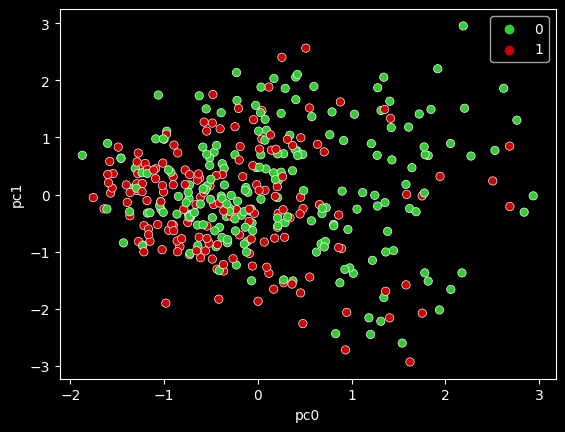

In [39]:
plt.style.use("dark_background")
sns.scatterplot(data = da, x= 'pc0', y = 'pc1', hue = ytr.values, palette = ["#33cc33", "#cc0000"])


<Axes: xlabel='pc0', ylabel='pc1'>

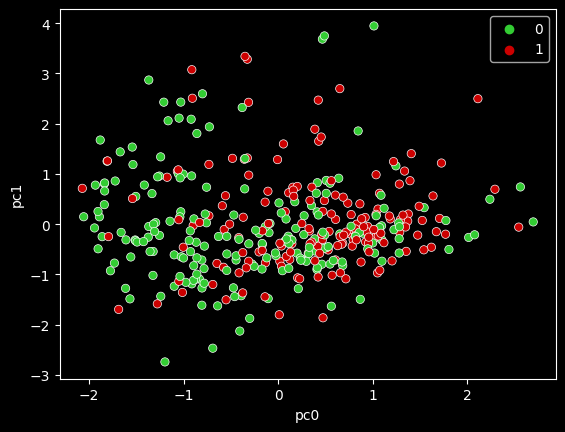

In [25]:
plt.style.use("dark_background")
sns.scatterplot(data = dx, x= 'pc0', y = 'pc1', hue = ytr.values, palette = ["#33cc33", "#cc0000"])

In [27]:

evals_result= {}
model_orig = xgb.XGBClassifier( n_estimators= 600,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 70,
                           )


tr_X =   orig_train# orig_train#
test_X = orig_test  # orig_test
ytr = ytr #y_train
yte = yte #y_test


model_orig.fit(tr_X, ytr.values,                   # Xtr, ytr
          early_stopping_rounds = 50,   # 10% of n_estimators
          eval_set=[ (test_X, yte.values)],
          eval_metric = ['auc']    # binary classification problem
          )



[18:43:35] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[18:43:35] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[18:43:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.66270
[18:43:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.75529
[18:43:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.72487
[18:43:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.74735
[18:43:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.77116
[18:43:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.76323

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=None, num_parallel_tree=None, ...)

In [34]:

evals_result= {}
model_trans = xgb.XGBClassifier( n_estimators= 600,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 70,
                           )


tr_X =   train_trans[fe_1[:200]]   # .iloc[:,6:]
test_X = test_trans[fe_1[:200]]    #.iloc[:,6:]
ytr = ytr #y_train
yte = yte #y_test


model_trans.fit(tr_X, ytr.values,                   # Xtr, ytr
          early_stopping_rounds = 80,   # 10% of n_estimators
          eval_set=[ (test_X, yte.values)],
          eval_metric = ['auc']    # binary classification problem
          )



[18:47:10] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[18:47:10] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[18:47:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.69841
[18:47:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.68519
[18:47:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.70899
[18:47:11] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.69709
[18:47:11] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.72222
[18:47:11] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.69841

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=None, num_parallel_tree=None, ...)

In [30]:
fe_1,fe_0 = utils.xgImptFeatures(model_trans,tr_X.columns)

Order of feature importance is by 'gain'


In [31]:
fe_1

['clu_calc_ck_ph',
 'eig_calc_ck_gravity',
 'eig_calc_ck_ph_p_calc',
 'pr_gravity_ck_ph_p_urea',
 'pr_gravity_ck_calc',
 'deg_calc_ck_gravity',
 'bet_urea_ck_osmo_p_calc',
 'clu_calc_ck_gravity_p_ph',
 'pr_gravity_ck_cond_p_urea',
 'pr_ph_ck_cond',
 'deg_osmo_ck_gravity_p_cond',
 'pr_calc_ck_gravity',
 'deg_urea_ck_ph_p_calc',
 'eig_urea_ck_osmo_p_cond',
 'pr_urea_ck_gravity_p_osmo',
 'eig_calc_ck_osmo_p_cond',
 'clu_cond_ck_gravity_p_osmo',
 'deg_gravity_ck_calc',
 'deg_urea_ck_ph',
 'bet_cond_ck_osmo_p_urea',
 'deg_calc_ck_urea',
 'clu_osmo_ck_ph_p_cond',
 'clu_calc_ck_ph_p_urea',
 'eig_calc_ck_gravity_p_calc',
 'bet_gravity_ck_osmo_p_urea',
 'bet_gravity_ck_cond_p_urea',
 'eig_osmo_ck_gravity_p_ph',
 'bet_osmo_ck_urea_p_calc',
 'eig_gravity_ck_gravity_p_osmo',
 'clu_ph_ck_urea',
 'pr_calc_ck_cond',
 'eig_calc_ck_ph',
 'bet_urea_ck_gravity_p_ph',
 'deg_ph_ck_gravity_p_osmo',
 'clu_gravity_ck_calc',
 'pr_osmo_ck_cond_p_urea',
 'deg_calc_ck_ph_p_urea',
 'deg_calc_ck_osmo_p_urea',
 'bet